[View in Colaboratory](https://colab.research.google.com/github/thispassing/colaboratory/blob/master/oct_14_feature_sets_study.ipynb)

In [89]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

print(california_housing_dataframe)


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1242      -117.1      32.9                14.0       1946.0           463.0   
5754      -118.2      34.0                33.0        151.0            83.0   
1802      -117.3      33.0                25.0       2582.0           495.0   
13474     -122.0      37.2                20.0       2345.0           322.0   
2959      -117.8      33.5                46.0       1033.0           223.0   
...          ...       ...                 ...          ...             ...   
5094      -118.1      33.9                29.0       2666.0           848.0   
4884      -118.1      34.0                37.0       1022.0           232.0   
6871      -118.3      33.9                35.0       3227.0           749.0   
13641     -122.0      37.0                31.0       3209.0           723.0   
13326     -121.9      36.6                52.0        974.0           190.0   

       population  households  median_income  media

In [0]:
def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[
      ["latitude",
      "longitude",
      "housing_median_age",
      "total_rooms",
      "total_bedrooms",
      "population",
      "households",
      "median_income"]]
  
  processed_features = selected_features.copy()
  processed_features["rooms_per_person"] = (
      california_housing_dataframe["total_rooms"] /
      california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  output_targets = pd.DataFrame()
  output_targets["median_house_value"] = (
      california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# print("Training examples summary")
# display.display(training_examples.describe())

# print("Training targets summary")
# display.display(training_targets.describe())

# print("Validation examples summary")
# display.display(validation_examples.describe())

# print("Validation targets summary")
# display.display(validation_targets.describe())



In [92]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]
correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [0]:
def construct_feature_columns(input_features):
 return set([tf.feature_column.numeric_column(my_feature)
            for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds = ds.shuffle(10000)
   
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels
  
  

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  periods = 10
  steps_per_period = steps/periods
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = construct_feature_columns(training_examples),
      optimizer = my_optimizer)
  
  training_input_fn = lambda: my_input_fn(training_examples,
                                         training_targets["median_house_value"],
                                         batch_size=batch_size)
  
  predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                 training_targets["median_house_value"],
                                                 num_epochs = 1,
                                                 shuffle=False)
  
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                   validation_targets["median_house_value"],
                                                   num_epochs = 1,
                                                   shuffle=False)

  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range(0,periods):
    linear_regressor.train(
        input_fn=training_input_fn,
        steps = steps_per_period)
  
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
  
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
  
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
  
    print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
  
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  
  print("Model training finished.")

  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor
  

Training model...
RMSE (on training data):
 period 00 : 225.65
 period 01 : 214.58
 period 02 : 203.63
 period 03 : 192.80
 period 04 : 182.13
 period 05 : 171.62
 period 06 : 161.31
 period 07 : 151.23
 period 08 : 141.48
 period 09 : 132.72
Model training finished.


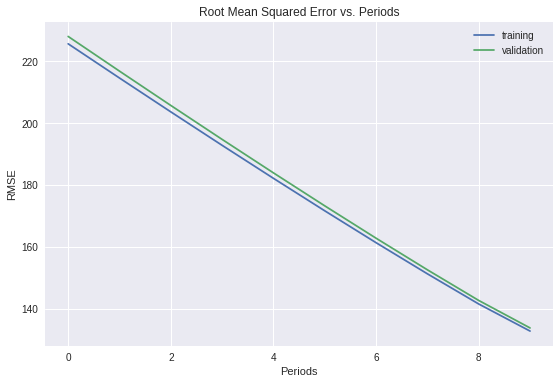

In [109]:
minimal_features = [
    "rooms_per_person",
    "median_income"]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets = training_targets,
    validation_examples = minimal_validation_examples,
    validation_targets = validation_targets)

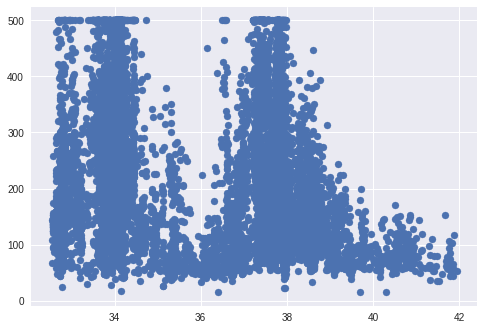

In [100]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [112]:
def select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32,44), range(33,45))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
  lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

print(selected_training_examples)

       median_income  latitude_32_to_33  latitude_33_to_34  latitude_34_to_35  \
1242             4.2                1.0                0.0                0.0   
5754             1.4                0.0                1.0                0.0   
1802             6.5                1.0                0.0                0.0   
13474           10.0                0.0                0.0                0.0   
2959             3.3                0.0                1.0                0.0   
...              ...                ...                ...                ...   
7986             6.2                0.0                1.0                0.0   
14104            5.7                0.0                0.0                0.0   
2868             3.5                0.0                0.0                1.0   
5576             5.1                0.0                1.0                0.0   
5886             3.9                0.0                1.0                0.0   

       latitude_35_to_36  l

Training model...
RMSE (on training data):
 period 00 : 226.56
 period 01 : 216.42
 period 02 : 206.35
 period 03 : 196.38
 period 04 : 186.54
 period 05 : 176.81
 period 06 : 167.24
 period 07 : 157.84
 period 08 : 148.99
 period 09 : 140.09
Model training finished.


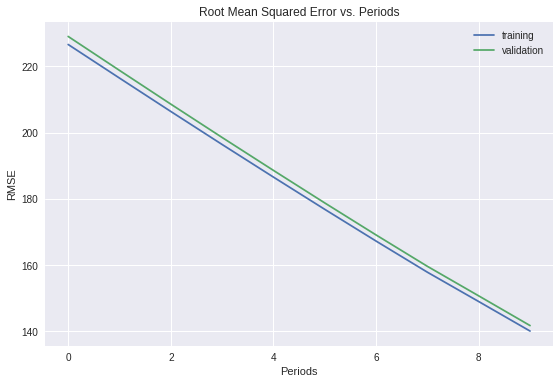

In [107]:
train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets = training_targets,
    validation_examples = selected_validation_examples,
    validation_targets = validation_targets)